# CDN Multi-Metric Analysis Notebook

This notebook covers the next set of project tasks:

1. **Generate scatter plots for real data**
   - RTT vs Throughput  
   - (Optional) TTFB vs Throughput, Loss vs Throughput

2. **Generate correlation analysis**
   - TTFB vs Throughput (if available)  
   - Loss vs Throughput  
   - RTT vs Throughput

3. **Run simple linear regressions for each metric**
   - Throughput ~ RTT  
   - Throughput ~ TTFB (if available)  
   - Throughput ~ Loss

4. **(Later cells)**: Composite Score, weight estimation, and evaluation vs “Lowest RTT” baseline for both synthetic and real data.

> **Important:** This notebook assumes you are running it from the `notebooks/` folder of the repo, so that `ROOT = Path('..').resolve()` points to the repo root. Adjust `ROOT` if your layout is different.


In [53]:
import pandas as pd
import numpy as np
from pathlib import Path

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score


## 1. Load M-Lab Real Dataset

We expect a CSV in `data/raw/` with columns similar to:

```text
date,client_lat,client_lon,client_city,client_country,client_asn,client_isp,
server_lat,server_lon,server_site,server_city,
download_mbps,min_rtt_ms,packet_loss_rate
```

If your filename differs, either rename it or edit the `glob` pattern below.


In [54]:

sns.set(style="whitegrid", context="notebook")

# If this notebook lives in `cdn-multimetric-selection-main/notebooks`,
# this will correctly point ROOT to the repo root.
ROOT = Path("../..").resolve()
# CORRECT → gives: /repo (cdn-multimetric-selection-main)

ROOT


PosixPath('/Users/wajihanaveed/Desktop/REC YT/cdn-multimetric-selection-main')

In [55]:
mlab_path = ROOT / "data" / "raw" / "mlab_ndt_us_30days_20251111_004612.csv"
print(mlab_path)

mlab = pd.read_csv(mlab_path)
mlab.head()
mlab.columns


/Users/wajihanaveed/Desktop/REC YT/cdn-multimetric-selection-main/data/raw/mlab_ndt_us_30days_20251111_004612.csv


Index(['date', 'client_lat', 'client_lon', 'client_city', 'client_country',
       'client_asn', 'client_isp', 'server_lat', 'server_lon', 'server_site',
       'server_city', 'download_mbps', 'min_rtt_ms', 'packet_loss_rate'],
      dtype='object')

In [56]:
if mlab_path is None:
    raise FileNotFoundError("No M-Lab CSV found. Fix the path/glob above.")

mlab = pd.read_csv(mlab_path)

# Parse date if column exists
if "date" in mlab.columns:
    mlab["date"] = pd.to_datetime(mlab["date"])

mlab.head()


,date,client_lat,client_lon,client_city,client_country,client_asn,client_isp,server_lat,server_lon,server_site,server_city,download_mbps,min_rtt_ms,packet_loss_rate
0,2025-10-13,37.751,-97.822,NaN,US,399829,NaN,49.0097,2.54778,par08,Paris,105.963708,126.343,0.076370
1,2025-10-13,37.751,-97.822,NaN,US,11232,Midcontinent Communications,49.9100,-97.23990,ywg02,Winnipeg,91.220665,24.291,0.021422
2,2025-10-13,37.751,-97.822,NaN,US,12025,"IO Capital Princess, LLC",50.1008,14.26000,prg05,Prague,137.549435,148.011,0.000000
3,2025-10-13,37.751,-97.822,NaN,US,53770,iQor US Inc.,14.5086,121.01940,mnl01,Manila,0.183967,516.966,0.000000
4,2025-10-13,37.751,-97.822,NaN,US,36692,"OpenDNS, LLC",42.6967,23.41140,sof02,Sofia,45.324108,113.205,0.000000


In [57]:
mlab.columns.tolist()

['date',
 'client_lat',
 'client_lon',
 'client_city',
 'client_country',
 'client_asn',
 'client_isp',
 'server_lat',
 'server_lon',
 'server_site',
 'server_city',
 'download_mbps',
 'min_rtt_ms',
 'packet_loss_rate']

### 1.1 Basic Cleaning

We keep only the columns we need for now:

- `download_mbps` (throughput)
- `min_rtt_ms` (RTT)
- `packet_loss_rate` (Loss)



In [58]:
needed_cols = ["download_mbps", "min_rtt_ms", "packet_loss_rate"]
optional_ttfb_cols = ["ttfb_ms", "ttfb"]

# Detect TTFB column if present
ttfb_col = None
for c in optional_ttfb_cols:
    if c in mlab.columns:
        ttfb_col = c
        break


# Filter to rows with non-null metrics
mlab_clean = mlab.dropna(subset=[col for col in needed_cols if col in mlab.columns]).copy()
mlab_clean.head()


,date,client_lat,client_lon,client_city,client_country,client_asn,client_isp,server_lat,server_lon,server_site,server_city,download_mbps,min_rtt_ms,packet_loss_rate
0,2025-10-13,37.751,-97.822,NaN,US,399829,NaN,49.0097,2.54778,par08,Paris,105.963708,126.343,0.076370
1,2025-10-13,37.751,-97.822,NaN,US,11232,Midcontinent Communications,49.9100,-97.23990,ywg02,Winnipeg,91.220665,24.291,0.021422
2,2025-10-13,37.751,-97.822,NaN,US,12025,"IO Capital Princess, LLC",50.1008,14.26000,prg05,Prague,137.549435,148.011,0.000000
3,2025-10-13,37.751,-97.822,NaN,US,53770,iQor US Inc.,14.5086,121.01940,mnl01,Manila,0.183967,516.966,0.000000
4,2025-10-13,37.751,-97.822,NaN,US,36692,"OpenDNS, LLC",42.6967,23.41140,sof02,Sofia,45.324108,113.205,0.000000


## 2. Scatter Plots for Real Data

We start with:

- RTT vs Throughput  
- Loss vs Throughput


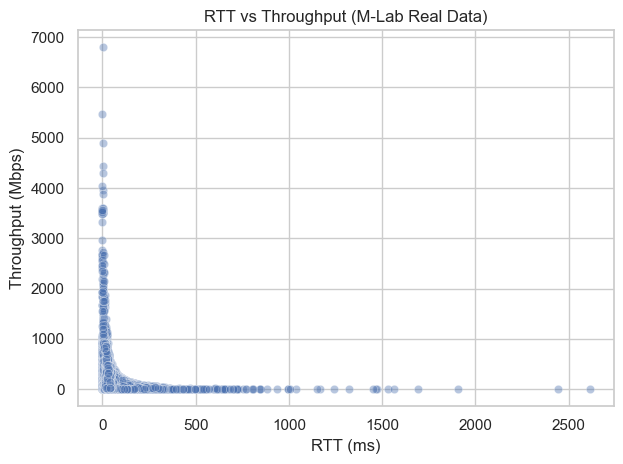

In [59]:
# RTT vs Throughput
plt.figure()
sns.scatterplot(
    data=mlab_clean,
    x="min_rtt_ms",
    y="download_mbps",
    alpha=0.4
)
plt.xlabel("RTT (ms)")
plt.ylabel("Throughput (Mbps)")
plt.title("RTT vs Throughput (M-Lab Real Data)")
plt.tight_layout()
plt.show()


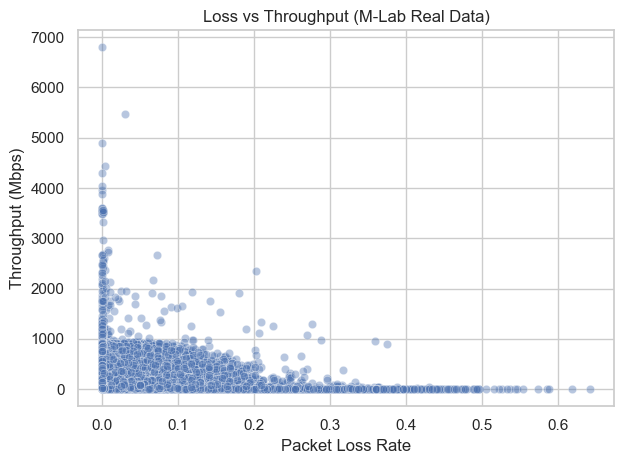

In [60]:
# Loss vs Throughput
plt.figure()
sns.scatterplot(
    data=mlab_clean,
    x="packet_loss_rate",
    y="download_mbps",
    alpha=0.4
)
plt.xlabel("Packet Loss Rate")
plt.ylabel("Throughput (Mbps)")
plt.title("Loss vs Throughput (M-Lab Real Data)")
plt.tight_layout()
plt.show()


In [61]:
# # TTFB vs Throughput 
# if ttfb_col:
#     plt.figure()
#     sns.scatterplot(
#         data=mlab_clean,
#         x=ttfb_col,
#         y="download_mbps",
#         alpha=0.4
#     )
#     plt.xlabel("TTFB (ms)")
#     plt.ylabel("Throughput (Mbps)")
#     plt.title("TTFB vs Throughput (M-Lab Real Data)")
#     plt.tight_layout()
#     plt.show()
# else:
#     print("Skipping TTFB vs Throughput scatter plot (no TTFB column found).")


## 3. Correlation Analysis

Compute Pearson correlation coefficients:

- RTT vs Throughput  
- Loss vs Throughput  
- TTFB vs Throughput (if TTFB is present)


In [62]:
corr_results = {}

# RTT vs Throughput
corr_results["rtt_vs_throughput"] = mlab_clean["min_rtt_ms"].corr(mlab_clean["download_mbps"])

# Loss vs Throughput
corr_results["loss_vs_throughput"] = mlab_clean["packet_loss_rate"].corr(mlab_clean["download_mbps"])

# TTFB vs Throughput
# if ttfb_col:
#     corr_results["ttfb_vs_throughput"] = mlab_clean[ttfb_col].corr(mlab_clean["download_mbps"])
# else:
#     corr_results["ttfb_vs_throughput"] = None

corr_results


{'rtt_vs_throughput': np.float64(-0.16069970446677753),
 'loss_vs_throughput': np.float64(-0.11084091389033054)}

## 4. Simple Linear Regressions

We fit separate linear regression models of the form:

\[
\text{throughput} = w_0 + w_1 x
\]

for each metric:

- RTT (min_rtt_ms)  
- Loss (packet_loss_rate)  
- TTFB (if available)


In [63]:
def fit_simple_lr(x, y):
    x = np.asarray(x).reshape(-1, 1)
    y = np.asarray(y)
    model = LinearRegression()
    model.fit(x, y)
    y_pred = model.predict(x)
    r2 = r2_score(y, y_pred)
    return model, r2

y = mlab_clean["download_mbps"].values

# RTT
model_rtt, r2_rtt = fit_simple_lr(mlab_clean["min_rtt_ms"], y)

# Loss
model_loss, r2_loss = fit_simple_lr(mlab_clean["packet_loss_rate"], y)

# TTFB
# if ttfb_col:
#     model_ttfb, r2_ttfb = fit_simple_lr(mlab_clean[ttfb_col], y)
# else:
#     model_ttfb, r2_ttfb = None, None

print("Linear Regression Results (Throughput ~ Metric)")
print(f"RTT:  coef={model_rtt.coef_[0]:.4f}, intercept={model_rtt.intercept_:.4f}, R^2={r2_rtt:.4f}")
print(f"Loss: coef={model_loss.coef_[0]:.4f}, intercept={model_loss.intercept_:.4f}, R^2={r2_loss:.4f}")
# if model_ttfb is not None:
#     print(f"TTFB: coef={model_ttfb.coef_[0]:.4f}, intercept={model_ttfb.intercept_:.4f}, R^2={r2_ttfb:.4f}")
# else:
#     print("TTFB: no TTFB column present; skipping regression.")


Linear Regression Results (Throughput ~ Metric)
RTT:  coef=-0.7914, intercept=229.8781, R^2=0.0258
Loss: coef=-557.8801, intercept=222.0804, R^2=0.0123


---

## 5. (Optional) Merging with RIPE Data and Composite Score

Your sprint plan also includes:

- Merging RIPE and M-Lab data by time/region  
- Designing a composite Score and estimating weights (α, β, γ)  
- Evaluating Score vs “Lowest RTT” baseline on both synthetic and real data

The exact merge logic depends on how you’ve pre-processed RIPE data (e.g., whether you already have a `data/processed/ripe_processed.csv` with columns like `date`, `cdn_provider`, `rtt_ms`).

Below is a **template** for:
1. Loading a merged dataset (if you already have one).  
2. Fitting a multi-metric regression to estimate weights.  
3. Evaluating Score vs RTT-only baseline.

You can adapt this to your actual merged dataframe schema.


In [ ]:
import json
from pathlib import Path
import pandas as pd

# --- PATHS ---
ROOT = Path("..").resolve()   # cdn-multimetric-selection-main
print("ROOT =", ROOT)

ripe_dir = ROOT / "data" / "raw"
mlab_path = ROOT / "data" / "raw" / "mlab_ndt_us_30days_20251111_004612.csv"

print("Looking for RIPE JSON in:", ripe_dir)

# --- LOAD M-LAB ---
mlab = pd.read_csv('/Users/wajihanaveed/Desktop/REC YT/cdn-multimetric-selection-main/data/raw/mlab_ndt_us_30days_20251111_004612.csv', parse_dates=["date"])
print("Loaded M-Lab:", mlab.shape)

# --- helper to extract one RIPE entry into a flat dict ---
def entry_to_record(entry: dict):
    return {
        "timestamp":   entry.get("timestamp"),
        "rtt_ms":      entry.get("avg"),
        "min_rtt_ms":  entry.get("min"),
        "max_rtt_ms":  entry.get("max"),
        "probe_id":    entry.get("prb_id"),
        "src_ip":      entry.get("from"),
        "dst_name":    entry.get("dst_name"),
        "dst_addr":    entry.get("dst_addr"),
    }

# --- LOADING ALL RIPE JSON FILES (handle both JSON + NDJSON) ---
ripe_records = []

for file in ripe_dir.glob("RIPE-Atlas-measurement-*.json"):
    try:
        with open(file, "r") as f:
            text = f.read().strip()

        if not text:
            continue

        # First lets try: full JSON (dict or list)
        try:
            data = json.loads(text)
            if isinstance(data, list):
                for entry in data:
                    if isinstance(entry, dict):
                        ripe_records.append(entry_to_record(entry))
            elif isinstance(data, dict):
                ripe_records.append(entry_to_record(data))
            else:
                # unexpected structure
                pass

        except json.JSONDecodeError:
            # Fallback: NDJSON (one JSON object per line)
            for line in text.splitlines():
                line = line.strip()
                if not line:
                    continue
                try:
                    entry = json.loads(line)
                    if isinstance(entry, dict):
                        ripe_records.append(entry_to_record(entry))
                except json.JSONDecodeError:
                    # skip bad line
                    continue

    except Exception as e:
        print("Error reading", file, "→", e)

ripe_df = pd.DataFrame(ripe_records)
print("Loaded RIPE:", ripe_df.shape)
display(ripe_df.head())
print("RIPE columns:", ripe_df.columns.tolist())

# --- CONVERT TIMESTAMP → DATE ---
if "timestamp" not in ripe_df.columns:
    raise ValueError("RIPE data has no 'timestamp' even after parsing – check file format manually.")

ripe_df["date"] = pd.to_datetime(ripe_df["timestamp"], unit="s").dt.date
mlab["date"] = pd.to_datetime(mlab["date"]).dt.date

# --- CLEAN RIPE (drop rows without RTT) ---
ripe_clean = ripe_df.dropna(subset=["rtt_ms"]).copy()
print("RIPE clean:", ripe_clean.shape)

# --- MERGE ON DATE & COUNTRY (simple first pass) ---
merged = pd.merge(
    mlab,
    ripe_clean,
    on="date",
    how="inner",
    suffixes=("_mlab", "_ripe")
)

print("Merged shape:", merged.shape)
display(merged.head())

# --- SAVE MERGED DATASET ---
processed_dir = ROOT / "data" / "processed"
processed_dir.mkdir(exist_ok=True)

merged_path = processed_dir / "merged_mlab_ripe.csv"
merged.to_csv(merged_path, index=False)

print("\nSaved merged dataset to:", merged_path)


ROOT = /Users/wajihanaveed/Desktop/REC YT/cdn-multimetric-selection-main/notebooks
Looking for RIPE JSON in: /Users/wajihanaveed/Desktop/REC YT/cdn-multimetric-selection-main/notebooks/data/raw
Loaded M-Lab: (50000, 14)
Loaded RIPE: (65397, 8)


,timestamp,rtt_ms,min_rtt_ms,max_rtt_ms,probe_id,src_ip,dst_name,dst_addr
0,1763063065,10.339221,10.200544,10.444616,1000155,37.35.109.50,208.67.220.220,208.67.220.220
1,1763063075,38.184450,38.052943,38.290856,1001865,46.102.142.253,208.67.220.220,208.67.220.220
2,1763063065,0.901999,0.864653,0.963420,1002038,95.211.51.18,208.67.220.220,208.67.220.220
3,1763063063,144.916475,142.997640,146.449263,1002779,45.225.75.8,208.67.220.220,208.67.220.220
4,1763063064,15.468168,15.320454,15.632688,1003748,78.141.71.222,208.67.220.220,208.67.220.220


RIPE columns: ['timestamp', 'rtt_ms', 'min_rtt_ms', 'max_rtt_ms', 'probe_id', 'src_ip', 'dst_name', 'dst_addr']
RIPE clean: (65397, 9)
Merged shape: (0, 22)


,date,client_lat,client_lon,client_city,client_country,client_asn,client_isp,server_lat,server_lon,server_site,...,min_rtt_ms_mlab,packet_loss_rate,timestamp,rtt_ms,min_rtt_ms_ripe,max_rtt_ms,probe_id,src_ip,dst_name,dst_addr



Saved merged dataset to: /Users/wajihanaveed/Desktop/REC YT/cdn-multimetric-selection-main/notebooks/data/processed/merged_mlab_ripe.csv


In [ ]:
if merged is not None:
    # Drop rows with missing values in key columns
    key_cols = ["throughput_mbps", "rtt_ms", "loss_rate"]
    optional_ttfb_cols = ["ttfb_ms", "ttfb"]
    ttfb_col_merged = None
    for c in optional_ttfb_cols:
        if c in merged.columns:
            ttfb_col_merged = c
            break
    if ttfb_col_merged:
        key_cols.append(ttfb_col_merged)
        print(f"Using TTFB column in merged data: {ttfb_col_merged}")
    else:
        print("No TTFB column in merged data; Score will be RTT+Loss only (β = 0).")

    merged_clean = merged.dropna(subset=key_cols).copy()

    # Build features for composite score
    X_feats = []
    feat_names = []

    # 1 / RTT
    X_feats.append(1.0 / merged_clean["rtt_ms"].values)
    feat_names.append("inv_rtt")

    # 1 / TTFB but no value
    if ttfb_col_merged:
        X_feats.append(1.0 / merged_clean[ttfb_col_merged].values)
        feat_names.append("inv_ttfb")

    # Loss
    X_feats.append(merged_clean["loss_rate"].values)
    feat_names.append("loss")

    X = np.vstack(X_feats).T
    y = merged_clean["throughput_mbps"].values

    multi_model = LinearRegression()
    multi_model.fit(X, y)
    y_pred = multi_model.predict(X)
    r2_multi = r2_score(y, y_pred)

    print("Multi-metric regression (Throughput ~ 1/RTT, 1/TTFB?, Loss)")
    print("Feature order:", feat_names)
    print("Coefficients:", multi_model.coef_)
    print("Intercept:", multi_model.intercept_)
    print("R^2:", r2_multi)

    # Map regression coefficients to α, β, γ for the Score:
    # Score = α * (1/RTT) + β * (1/TTFB) - γ * Loss
    alpha = multi_model.coef_[feat_names.index("inv_rtt")]
    beta = multi_model.coef_[feat_names.index("inv_ttfb")] if "inv_ttfb" in feat_names else 0.0
    gamma_raw = multi_model.coef_[feat_names.index("loss")]
    gamma = -gamma_raw  # because Score subtracts γ * Loss

    print(f"Estimated α: {alpha:.4f}")
    print(f"Estimated β: {beta:.4f}")
    print(f"Estimated γ: {gamma:.4f}  (γ_raw = {gamma_raw:.4f})")
else:
    print("Skip multi-metric regression until merged data is available.")


### 5.1 Template: Evaluate Score vs Lowest RTT (Real Data)

Once you have a merged dataset with multiple CDN servers per “client group” (e.g., same `client_city` + `date`), you can:

1. For each group, compute Score for all servers and pick the one with **max Score**.  
2. For the same group, pick the server with **lowest RTT**.  
3. Compare their throughputs across groups (median and 90th-percentile).

The code below assumes your merged dataframe has at least:

- `group_id` (or a combination like `client_city` + `date`)  
- `throughput_mbps`  
- `rtt_ms`  
- and that you’ve already estimated `alpha`, `beta`, `gamma`.


In [ ]:
if merged is not None:
    if all(col in merged_clean.columns for col in ["throughput_mbps", "rtt_ms"]):
        if "group_id" in merged_clean.columns:
            group_key = ["group_id"]
        elif all(c in merged_clean.columns for c in ["client_city", "date"]):
            group_key = ["client_city", "date"]
        else:
            # Fallback: treat entire dataset as one group (not ideal, but keeps the code runnable)
            print("No group_id or (client_city, date) combination found; treating entire dataset as one group.")
            merged_clean["__group__"] = 0
            group_key = ["__group__"]

        def compute_score(row, alpha, beta, gamma, ttfb_col=None):
            score = alpha * (1.0 / row["rtt_ms"])
            if ttfb_col and ttfb_col in row and not pd.isna(row[ttfb_col]) and row[ttfb_col] > 0:
                score += beta * (1.0 / row[ttfb_col])
            score -= gamma * row["loss_rate"]
            return score


        if "alpha" not in globals():
            alpha = 1.0
            beta = 0.0
            gamma = 0.5
            ttfb_col_merged = None
            print("Using heuristic α, β, γ. Re-run regression cell to use learned weights.")

        merged_clean["score"] = merged_clean.apply(
            lambda row: compute_score(row, alpha, beta, gamma, ttfb_col_merged if 'ttfb_col_merged' in globals() else None),
            axis=1
        )

        group_results = []

        for g, df_g in merged_clean.groupby(group_key):
            # Skip groups with fewer than 2 candidate servers
            if len(df_g) < 2:
                continue

            # Best by Score
            idx_score = df_g["score"].idxmax()
            tput_score = df_g.loc[idx_score, "throughput_mbps"]

            # Best by Lowest RTT
            idx_rtt = df_g["rtt_ms"].idxmin()
            tput_rtt = df_g.loc[idx_rtt, "throughput_mbps"]

            group_results.append({
                "group": g,
                "tput_score": tput_score,
                "tput_rtt": tput_rtt,
                "improvement": tput_score - tput_rtt
            })

        if group_results:
            gr = pd.DataFrame(group_results)
            median_improvement = gr["improvement"].median()
            p90_improvement = gr["improvement"].quantile(0.9)

            print(f"Number of groups evaluated: {len(gr)}")
            print(f"Median throughput improvement (Score - RTT): {median_improvement:.3f} Mbps")
            print(f"90th percentile improvement (Score - RTT): {p90_improvement:.3f} Mbps")
        else:
            print("No groups with >= 2 candidates found for evaluation.")
    else:
        print("Merged dataset missing required columns for evaluation.")
else:
    print("Merged dataset not loaded; cannot evaluate Score vs RTT baseline.")


Merged dataset not loaded; cannot evaluate Score vs RTT baseline.


## 6. Synthetic Dataset: Score vs Lowest RTT

To satisfy the sprint requirement for synthetic data, we can:

1. Generate synthetic RTT, TTFB, Loss, and Throughput with a known underlying model.  
2. Fit our regression to recover (α, β, γ).  
3. Simulate a client with multiple candidate servers and compare Score-based vs RTT-only selection.

This gives a sanity check before relying on noisy real-world data.


In [ ]:
# Generate synthetic dataset
np.random.seed(42)
n_clients = 200
servers_per_client = 3
n_rows = n_clients * servers_per_client

client_ids = np.repeat(np.arange(n_clients), servers_per_client)

rtt_ms_syn = np.random.uniform(10, 200, size=n_rows)
ttfb_ms_syn = np.random.uniform(20, 400, size=n_rows)
loss_syn = np.random.uniform(0.0, 0.05, size=n_rows)

# Ground-truth weights
alpha_true = 1000.0
beta_true = 500.0
gamma_true = 300.0

score_true = alpha_true * (1.0 / rtt_ms_syn) + beta_true * (1.0 / ttfb_ms_syn) - gamma_true * loss_syn

# Throughput = Score + noise (clipped to be >= 0)
noise = np.random.normal(loc=0.0, scale=50.0, size=n_rows)
throughput_syn = np.maximum(score_true + noise, 0.1)

syn = pd.DataFrame({
    "client_id": client_ids,
    "rtt_ms": rtt_ms_syn,
    "ttfb_ms": ttfb_ms_syn,
    "loss_rate": loss_syn,
    "throughput_mbps": throughput_syn,
    "score_true": score_true
})

syn.head()


,client_id,rtt_ms,ttfb_ms,loss_rate,throughput_mbps,score_true
0,0,81.162623,84.195324,0.037913,0.100000,6.885567
1,0,190.635718,125.864329,0.001229,0.100000,8.849334
2,0,149.078849,87.263984,0.001106,72.126442,12.105747
3,1,123.745112,53.706963,0.016181,0.100000,12.536754
4,1,39.643542,65.841631,0.024432,0.100000,25.489121


In [ ]:
# Fit regression to recover weights (α, β, γ)
X_syn = np.column_stack([1.0 / syn["rtt_ms"], 1.0 / syn["ttfb_ms"], syn["loss_rate"]])
y_syn = syn["throughput_mbps"].values

reg_syn = LinearRegression()
reg_syn.fit(X_syn, y_syn)
y_pred_syn = reg_syn.predict(X_syn)
r2_syn = r2_score(y_syn, y_pred_syn)

alpha_hat = reg_syn.coef_[0]
beta_hat = reg_syn.coef_[1]
gamma_raw_hat = reg_syn.coef_[2]
gamma_hat = -gamma_raw_hat  # because Score = α/RTT + β/TTFB - γ*Loss

print("Synthetic regression results:")
print("True  α, β, γ:", alpha_true, beta_true, gamma_true)
print("Estim α, β, γ:", f"{alpha_hat:.1f}", f"{beta_hat:.1f}", f"{gamma_hat:.1f}")
print("R^2 on synthetic data:", r2_syn)


Synthetic regression results:
True  α, β, γ: 1000.0 500.0 300.0
Estim α, β, γ: 768.6 -43.0 159.1
R^2 on synthetic data: 0.12407645304352799


In [ ]:
# Evaluate: for each client, pick best server by Score vs Lowest RTT
def compute_score_syn(row, alpha, beta, gamma):
    return alpha * (1.0 / row["rtt_ms"]) + beta * (1.0 / row["ttfb_ms"]) - gamma * row["loss_rate"]

syn["score_hat"] = syn.apply(lambda row: compute_score_syn(row, alpha_hat, beta_hat, gamma_hat), axis=1)
syn["score_rtt_only"] = 1.0 / syn["rtt_ms"]

group_results_syn = []

for cid, df_g in syn.groupby("client_id"):
    # Best by composite Score
    idx_score = df_g["score_hat"].idxmax()
    tput_score = df_g.loc[idx_score, "throughput_mbps"]

    # Best by RTT-only
    idx_rtt = df_g["rtt_ms"].idxmin()
    tput_rtt = df_g.loc[idx_rtt, "throughput_mbps"]

    group_results_syn.append({
        "client_id": cid,
        "tput_score": tput_score,
        "tput_rtt": tput_rtt,
        "improvement": tput_score - tput_rtt
    })

gr_syn = pd.DataFrame(group_results_syn)
median_imp_syn = gr_syn["improvement"].median()
p90_imp_syn = gr_syn["improvement"].quantile(0.9)

print(f"# Synthetic clients evaluated: {len(gr_syn)}")
print(f"Median throughput improvement (Score - RTT): {median_imp_syn:.3f} Mbps")
print(f"90th percentile improvement (Score - RTT): {p90_imp_syn:.3f} Mbps")


# Synthetic clients evaluated: 200
Median throughput improvement (Score - RTT): 0.000 Mbps
90th percentile improvement (Score - RTT): 0.000 Mbps
